# WITHOUT GAN AUGMENTATION

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
image_size = 256
batch_size = 10 #number of image for each trainning
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalization into mean
DIR_All='C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/TRIN/Newdata/Train/All_in'
folder_All = ImageFolder(DIR_All, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
train_All = DataLoader(folder_All, batch_size, shuffle=True, num_workers=3)#, pin_memory=True)

In [6]:
print(train_All)

In [17]:
DIR_Test='C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/TRIN/Newdata/Test'
folder_Test = ImageFolder(DIR_Test, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
test_All = DataLoader(folder_Test, batch_size, shuffle=False, num_workers=3)#, pin_memory=True)

In [5]:
#DIR_Horse='C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/TRIN/Newdata/Train/Horse_train'
#folder_Horse = ImageFolder(DIR_Horse, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))

#DIR_Cow='C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/TRIN/Newdata/Train/Cow_train'
#folder_Cow = ImageFolder(DIR_Cow, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))

In [6]:
#train_Horse = DataLoader(folder_Horse, batch_size, shuffle=True, num_workers=2)#, pin_memory=True)
#train_Cow = DataLoader(folder_Cow, batch_size, shuffle=True, num_workers=2)#, pin_memory=True)

In [18]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=256):
    fig, ax = plt.subplots(figsize=(10, 50))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=256):
    for images, _ in dl:
        show_images(images, nmax)
        break

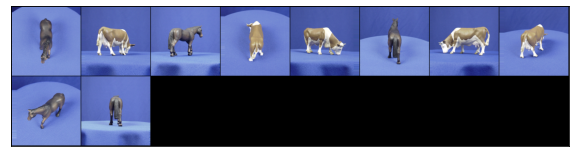

In [19]:
show_batch(train_All)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Sublayer(nn.Module):
    def __init__(self, input_channels):
        super(Sublayer, self).__init__()
        self.conv = nn.Conv2d(input_channels, input_channels*2, 4, 2, 1)
        self.batch= nn.BatchNorm2d(input_channels*2)
        self.relu =nn.ReLU(True)
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x
    def get_self(self):
        return self
    
class NetClass(nn.Module):
    def __init__(self):
        super(NetClass, self).__init__()
        self.conv = nn.Conv2d(3, 16, 4, 2, 1)
        self.batch= nn.BatchNorm2d(16)
        self.relu =nn.ReLU(True)
        self.lay1=Sublayer(16)
        self.lay2=Sublayer(32)
        self.lay3=Sublayer(64)
        self.lay4=Sublayer(128)
        self.lay5=Sublayer(256)
        self.lay6=Sublayer(512)
        self.maxpool =nn.MaxPool2d((2,2))
        self.fc = nn.Linear(1024,2)
    def forward(self,x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.lay1(x)
        x = self.lay2(x)
        x = self.lay3(x)
        x = self.lay4(x)
        x = self.lay5(x)
        x = self.lay6(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), 1024)
        x = self.fc(x)
        return x
net = NetClass()

In [4]:
8224-16*(4*4*32+1)

16

In [6]:
32*(4*4*16+1)

8224

In [7]:
64*(4*4*32+1)

32832

In [8]:
16*(4*4*3+1)

784

In [2]:
64*64*32

131072

In [10]:
#pip install torchsummary

In [21]:
from torchsummary import summary
model=NetClass()
summary(model,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             784
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4           [-1, 32, 64, 64]           8,224
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
          Sublayer-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 32, 32]          32,832
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
         Sublayer-11           [-1, 64, 32, 32]               0
           Conv2d-12          [-1, 128, 16, 16]         131,200
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [36]:
x = torch.zeros(18, 3, 256, 256)
scores = model(x)
print(scores.shape)

torch.Size([18, 2])


In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0002)#, momentum=0.9)

In [24]:
# Train the model
import numpy as np
total_step = len(train_All)
loss_list = []
acc_list = []
num_epochs = 10

for epoch in range(num_epochs):
    for i, (data,label) in enumerate(train_All):
        outputs = net(data)
        loss = criterion(outputs, label)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = label.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == label).sum().item()
        acc_list.append(correct / total)

       
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/10], Step [1/9], Loss: 0.9476, Accuracy: 40.00%
Epoch [1/10], Step [2/9], Loss: 0.5951, Accuracy: 70.00%
Epoch [1/10], Step [3/9], Loss: 0.7675, Accuracy: 50.00%
Epoch [1/10], Step [4/9], Loss: 0.5940, Accuracy: 60.00%
Epoch [1/10], Step [5/9], Loss: 0.4041, Accuracy: 80.00%
Epoch [1/10], Step [6/9], Loss: 0.7380, Accuracy: 40.00%
Epoch [1/10], Step [7/9], Loss: 0.5560, Accuracy: 50.00%
Epoch [1/10], Step [8/9], Loss: 0.6453, Accuracy: 40.00%
Epoch [1/10], Step [9/9], Loss: 1.3868, Accuracy: 0.00%
Epoch [2/10], Step [1/9], Loss: 0.3968, Accuracy: 100.00%
Epoch [2/10], Step [2/9], Loss: 0.3969, Accuracy: 100.00%
Epoch [2/10], Step [3/9], Loss: 0.4752, Accuracy: 80.00%
Epoch [2/10], Step [4/9], Loss: 0.5182, Accuracy: 70.00%
Epoch [2/10], Step [5/9], Loss: 0.4469, Accuracy: 90.00%
Epoch [2/10], Step [6/9], Loss: 0.5733, Accuracy: 70.00%
Epoch [2/10], Step [7/9], Loss: 0.3806, Accuracy: 90.00%
Epoch [2/10], Step [8/9], Loss: 0.3615, Accuracy: 100.00%
Epoch [2/10], Step [9/9], Los

# TEST

In [25]:
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_All:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(correct/total)

0.36585365853658536


In [48]:
PATH = 'CNN_without_GAN.pth'
torch.save(net.state_dict(), PATH)

In [50]:
len(loss_list)

300

In [53]:
it=[i for i in range(len(loss_list))]
len(it)

300

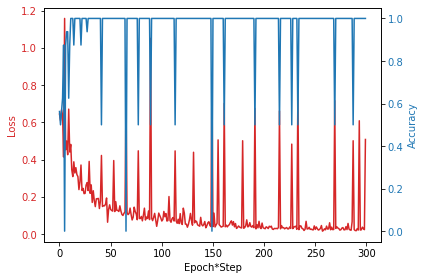

In [54]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch*Step')
ax1.set_ylabel('Loss', color=color)
ax1.plot(it, loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot(it, acc_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [7]:
for i, (a,b) in enumerate(zip(train_Cow, train_Horse)):
    [C,label_cow]=a
    [H,label_horse]=b
    #m1,m2,m3=a1
    #print(m1)
    print(label_cow)
    print(label_horse)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])


In [59]:
len(train_Horse)

41

In [98]:
torch.ones(3,dtype=torch.int32)

tensor([1, 1, 1], dtype=torch.int32)

In [95]:
label_Cow=torch.zeros(batch_size)
label_Horse=torch.ones(batch_size)
labels_train = torch.cat((label_Cow,label_Horse),0)

labels_train

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [33]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


nettest = Net()

In [ ]:
summary(model,(3, 256, 256))

In [45]:
for i, (C,l_C) in enumerate(train_Cow):
    print(l_C)
    print(net(C).shape)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([16, 10])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([16, 10])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([9, 10])


In [39]:
for i, (data,label) in enumerate(train_All):
    print(label)
    print(data.shape)

tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1])
torch.Size([16, 3, 256, 256])
tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0])
torch.Size([16, 3, 256, 256])
tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0])
torch.Size([16, 3, 256, 256])
tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0])
torch.Size([16, 3, 256, 256])
tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
torch.Size([16, 3, 256, 256])
tensor([0, 1])
torch.Size([2, 3, 256, 256])


In [79]:
[i,data,label]=train_Cow
#print(i)
#print(data)
print(label.shape)

AttributeError: 'list' object has no attribute 'shape'

In [62]:
[k,t]=label
print(t)
print(k.shape)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([9, 3, 256, 256])


In [57]:
print(data)

[tensor([[[[-0.4980, -0.4980, -0.4980,  ..., -0.3804, -0.3961, -0.3725],
          [-0.4745, -0.4745, -0.4745,  ..., -0.3961, -0.3961, -0.4039],
          [-0.4902, -0.4902, -0.4902,  ..., -0.3804, -0.3961, -0.3725],
          ...,
          [-0.3882, -0.3882, -0.3882,  ..., -0.2941, -0.2863, -0.2627],
          [-0.3725, -0.3725, -0.3725,  ..., -0.2941, -0.3020, -0.2549],
          [-0.3333, -0.3333, -0.3333,  ..., -0.2863, -0.3098, -0.3333]],

         [[-0.3647, -0.3647, -0.3647,  ..., -0.2549, -0.2706, -0.2471],
          [-0.3647, -0.3647, -0.3647,  ..., -0.2549, -0.2627, -0.2627],
          [-0.3569, -0.3569, -0.3569,  ..., -0.2549, -0.2549, -0.2471],
          ...,
          [-0.2157, -0.2157, -0.2157,  ..., -0.1059, -0.0980, -0.0902],
          [-0.2157, -0.2157, -0.2157,  ..., -0.1137, -0.1294, -0.0745],
          [-0.1922, -0.1922, -0.1922,  ..., -0.1059, -0.1451, -0.1608]],

         [[ 0.2078,  0.2078,  0.2078,  ...,  0.3647,  0.3647,  0.3569],
          [ 0.1922,  0.1922, 